In [3]:
!pip install pmdarima

In [4]:
pip install numpy pandas matplotlib seaborn pmdarima statsmodels scikit-learn tensorflow 

Note: you may need to restart the kernel to use updated packages.


In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


from math import sqrt
from sklearn.metrics import mean_squared_error


In [5]:
!pip install pmdarima

In [8]:
data = pd.read_csv('covid_19_clean_complete.csv')

In [10]:
data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Lat,49068.0,21.433730,24.950320,-51.7963,7.873054,23.6345,41.204380,7.170690e+01
Long,49068.0,23.528236,70.442740,-135.0000,-15.310100,21.7453,80.771797,1.780650e+02
Confirmed,49068.0,16884.904255,127300.205272,0.0000,4.000000,168.0000,1518.250000,4.290259e+06
Deaths,49068.0,884.179160,6313.584411,0.0000,0.000000,2.0000,30.000000,1.480110e+05
Recovered,49068.0,7915.713479,54800.918731,0.0000,0.000000,29.0000,666.000000,1.846641e+06
Active,49068.0,8085.011617,76258.903026,-14.0000,0.000000,26.0000,606.000000,2.816444e+06


In [12]:
#Display a concise summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


In [125]:
data.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region'],
      dtype='object')

In [126]:
data.index

RangeIndex(start=0, stop=49068, step=1)

In [127]:
data.shape

(49068, 10)

In [16]:
data.dtypes

Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths              int64
Recovered           int64
Active              int64
WHO Region         object
dtype: object

In [18]:
#check for missing values
data.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

In [19]:
df = data[["Date","Confirmed","Deaths","Recovered","Active"]]

In [20]:
df

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-22,0,0,0,0
1,2020-01-22,0,0,0,0
2,2020-01-22,0,0,0,0
3,2020-01-22,0,0,0,0
4,2020-01-22,0,0,0,0
...,...,...,...,...,...
49063,2020-07-27,865,14,734,117
49064,2020-07-27,1691,483,833,375
49065,2020-07-27,354,7,328,19
49066,2020-07-27,7235,60,6028,1147


In [21]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.set_index(df['Date']).drop("Date",axis=1).resample('D').sum()

In [22]:
df

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-01-22,555,17,28,510
2020-01-23,654,18,30,606
2020-01-24,941,26,36,879
2020-01-25,1434,42,39,1353
2020-01-26,2118,56,52,2010
...,...,...,...,...
2020-07-23,15510481,633506,8710969,6166006
2020-07-24,15791645,639650,8939705,6212290
2020-07-25,16047190,644517,9158743,6243930


Text(0.5, 1.0, 'Confirmed')

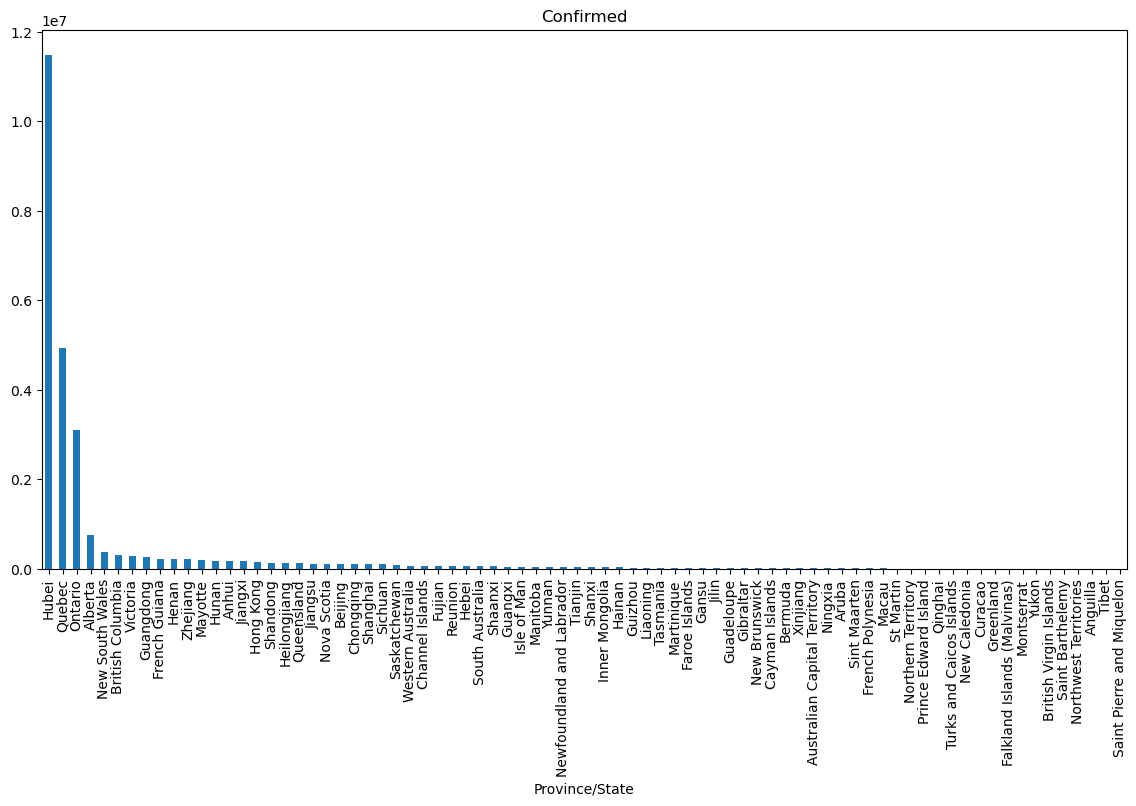

In [23]:
plt.figure(figsize=(14, 7))
data.groupby("Province/State")["Confirmed"].sum().sort_values(ascending=False).plot.bar()
plt.title("Confirmed")

Text(0.5, 1.0, 'Deaths')

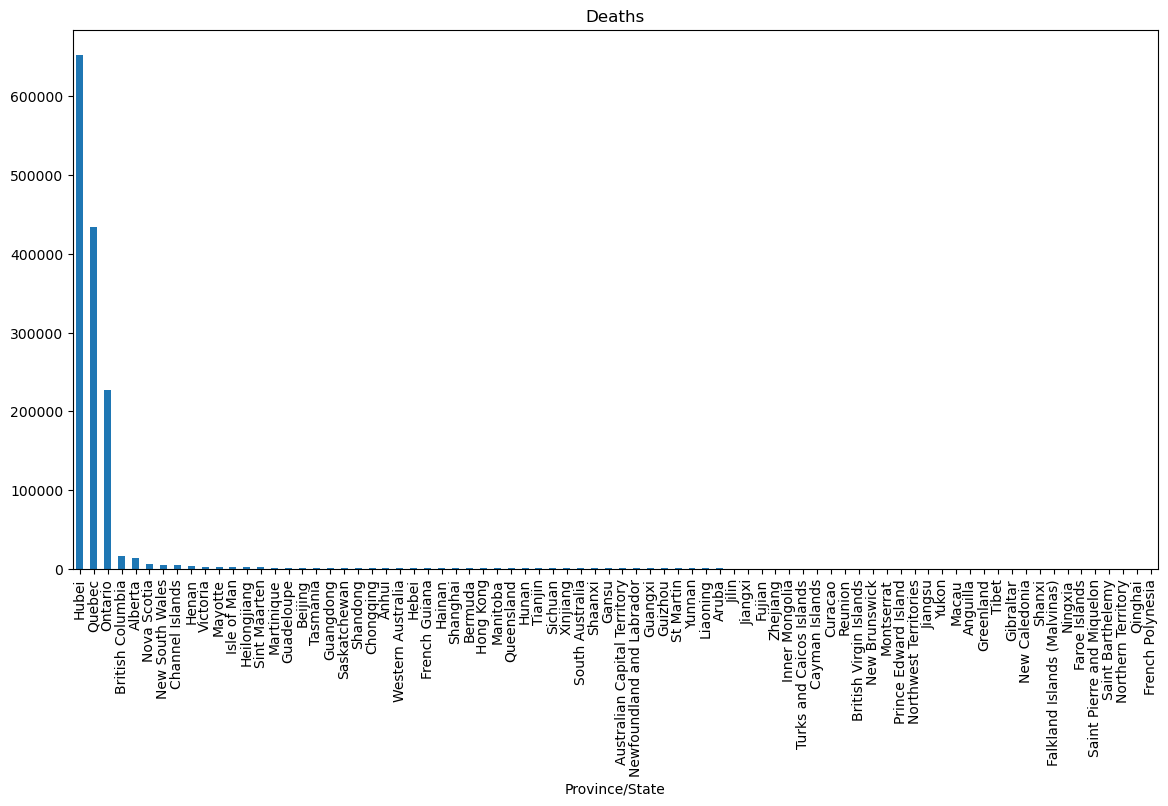

In [24]:
plt.figure(figsize=(14, 7))
data.groupby("Province/State")["Deaths"].sum().sort_values(ascending=False).plot.bar()
plt.title("Deaths")

Text(0.5, 1.0, 'Recovered')

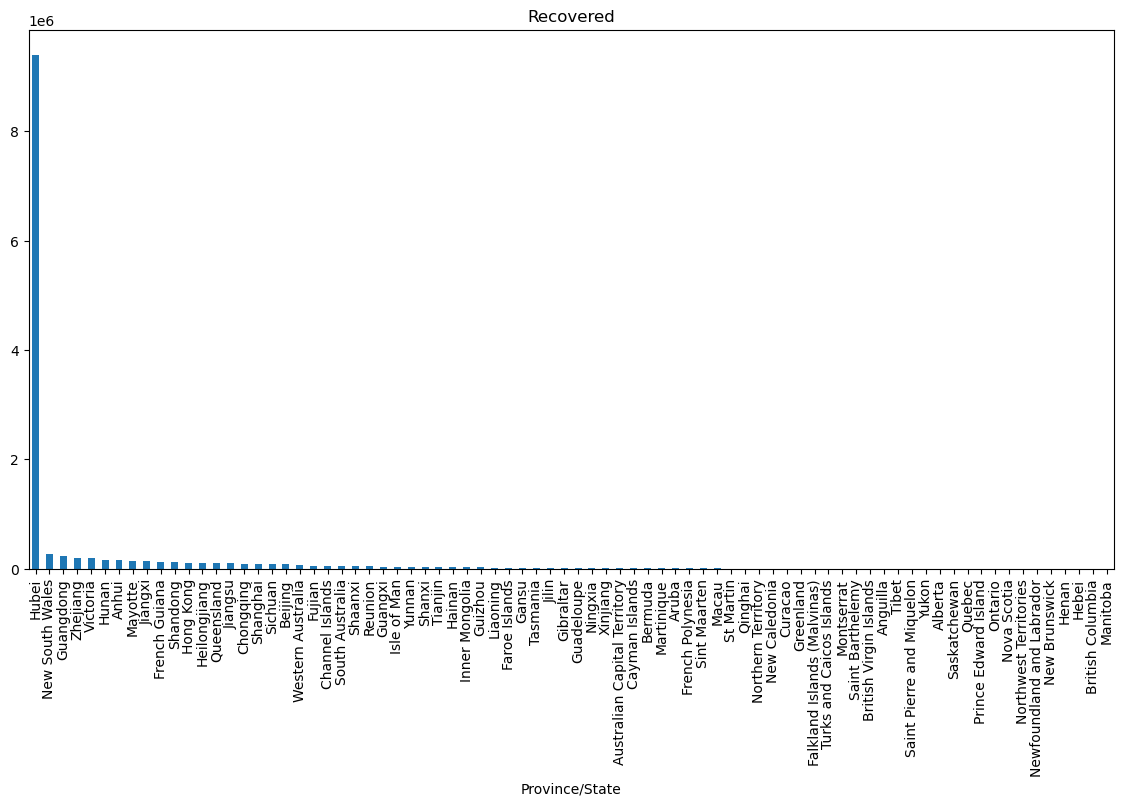

In [25]:
plt.figure(figsize=(14, 7))
data.groupby("Province/State")["Recovered"].sum().sort_values(ascending=False).plot.bar()
plt.title("Recovered")

Text(0.5, 1.0, 'Active')

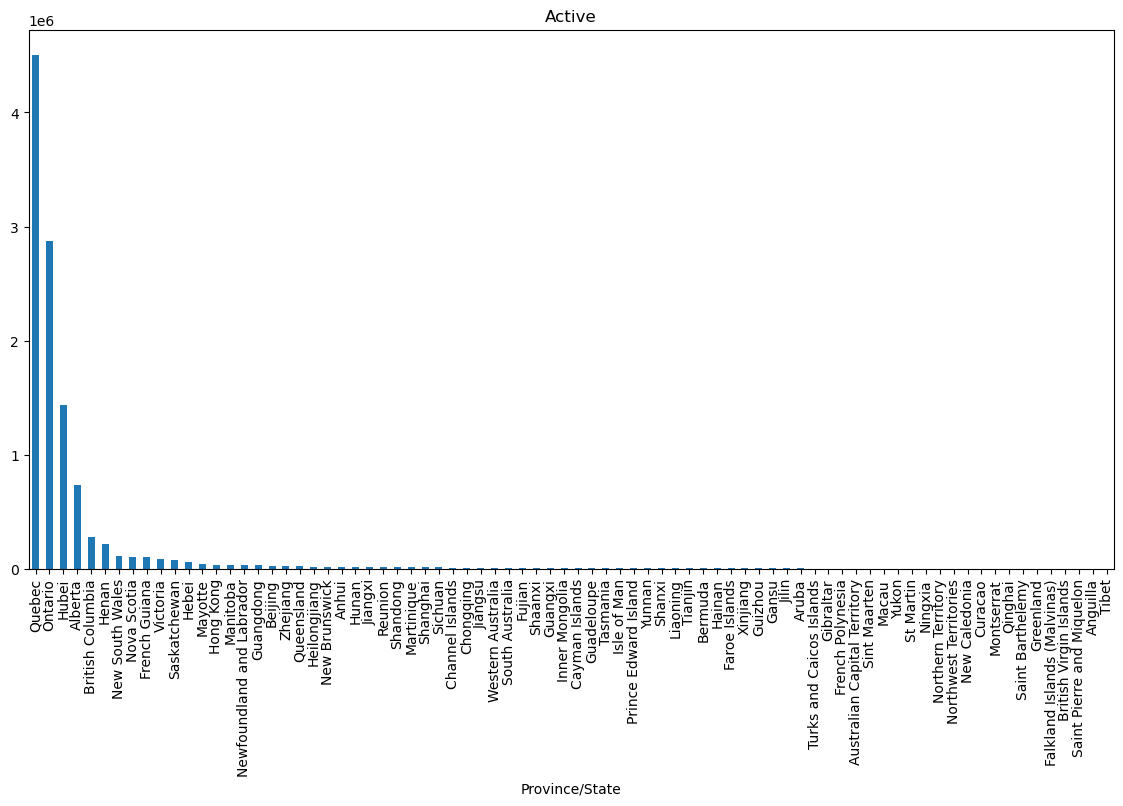

In [26]:
plt.figure(figsize=(14, 7))
data.groupby("Province/State")["Active"].sum().sort_values(ascending=False).plot.bar()
plt.title("Active")

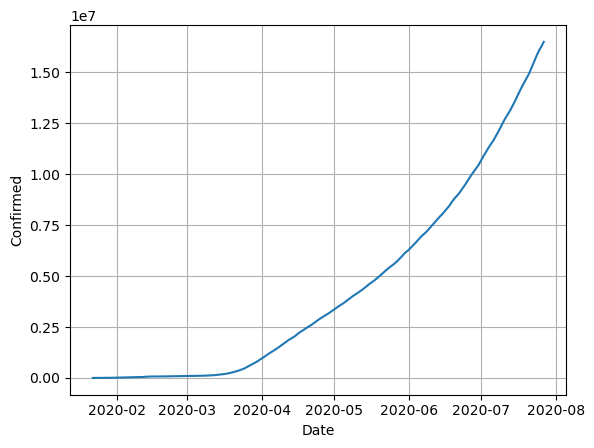

In [27]:
sns.lineplot(df, x=df.index, y="Confirmed")
plt.grid(True)

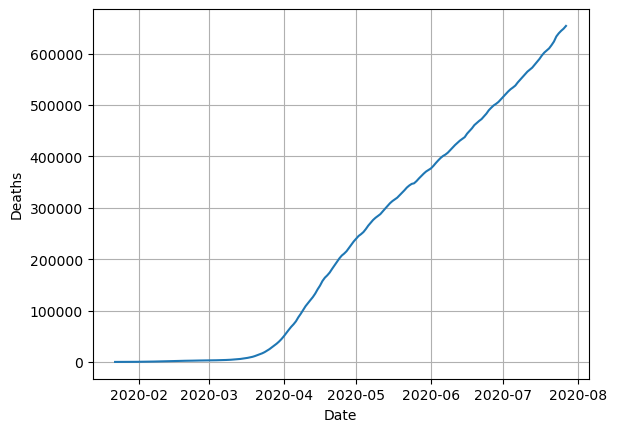

In [28]:
sns.lineplot(df, x=df.index, y="Deaths")
plt.grid(True)

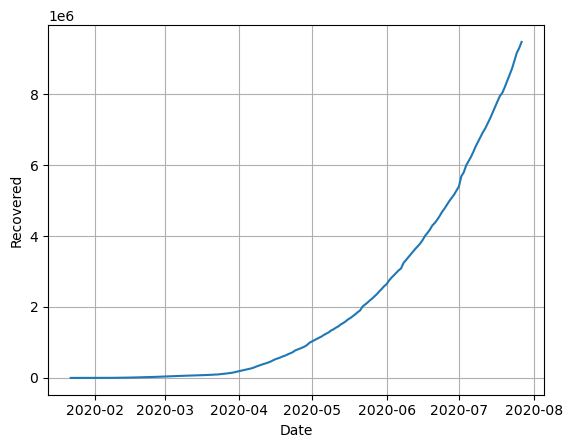

In [29]:
sns.lineplot(df, x=df.index, y="Recovered")
plt.grid(True)

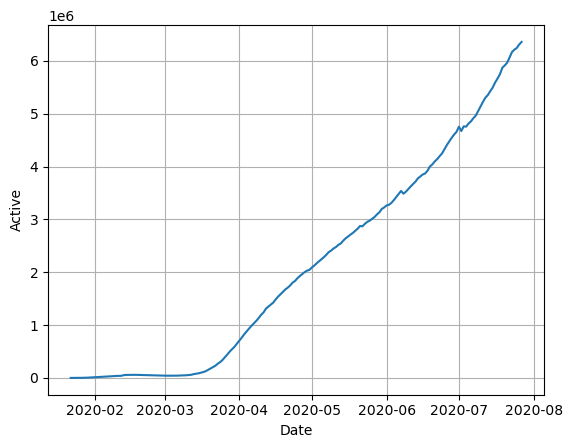

In [30]:
sns.lineplot(df, x=df.index, y="Active")
plt.grid(True)

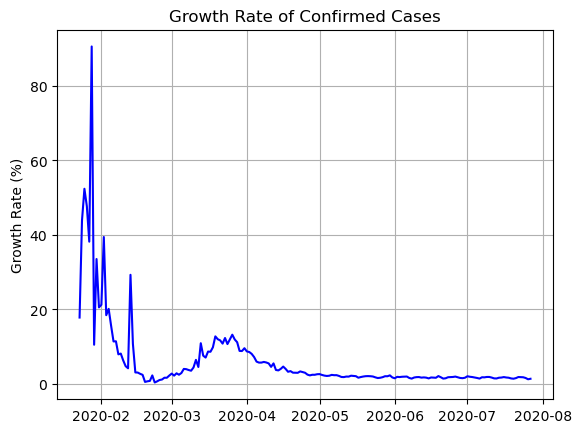

In [31]:
df['Growth Rate'] = (df["Confirmed"] - df["Confirmed"].shift(1)) / df["Confirmed"].shift(1) * 100
plt.plot(df.index, df['Growth Rate'], linestyle='-', color='b')
plt.xlabel(None)
plt.ylabel('Growth Rate (%)')
plt.title("Growth Rate of Confirmed Cases")
plt.grid(True)

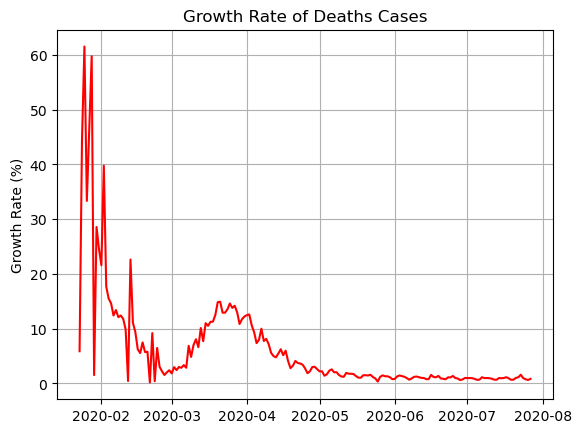

In [32]:
df['Growth Rate'] = (df["Deaths"] - df["Deaths"].shift(1)) / df["Deaths"].shift(1) * 100
plt.plot(df.index, df['Growth Rate'], linestyle='-', color='r')
plt.xlabel(None)
plt.ylabel('Growth Rate (%)')
plt.title("Growth Rate of Deaths Cases")
plt.grid(True)

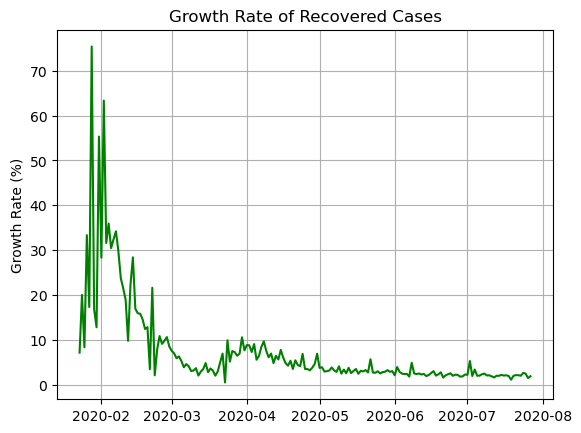

In [33]:
df['Growth Rate'] = (df["Recovered"] - df["Recovered"].shift(1)) / df["Recovered"].shift(1) * 100
plt.plot(df.index, df['Growth Rate'], linestyle='-', color='g')
plt.xlabel(None)
plt.ylabel('Growth Rate (%)')
plt.title("Growth Rate of Recovered Cases")
plt.grid(True)

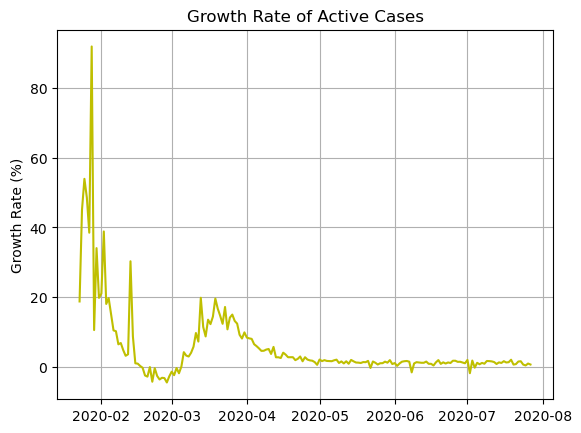

In [34]:
df['Growth Rate'] = (df["Active"] - df["Active"].shift(1)) / df["Active"].shift(1) * 100
plt.plot(df.index, df['Growth Rate'], linestyle='-', color='y')
plt.xlabel(None)
plt.ylabel('Growth Rate (%)')
plt.title("Growth Rate of Active Cases")
plt.grid(True)

In [35]:
stepwise_fit_confrimed = auto_arima(df["Confirmed"],trace=True,suppress_warnings=True)
stepwise_fit_confrimed.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3942.702, Time=0.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4035.993, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4037.518, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4037.262, Time=0.00 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4020.552, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4009.638, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3941.823, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=4004.103, Time=0.06 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=3956.936, Time=0.15 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=3940.025, Time=0.30 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=3936.329, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3997.790, Time=0.08 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=3978.639, Time=0.31 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=3979.990, Time=0.15 sec
 ARIMA(3,2,4)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(3, 2, 5)   Log Likelihood               -1946.381
Date:                Fri, 22 Nov 2024   AIC                           3910.762
Time:                        04:34:53   BIC                           3939.794
Sample:                    01-22-2020   HQIC                          3922.527
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5849      0.227      6.972      0.000       1.139       2.030
ar.L2         -1.4294      0.286     -4.995      0.000      -1.990      -0.869
ar.L3          0.3487      0.233      1.497      0.134      -0.108       0.805
ma.L1         -2.0783      0.205    -10.152      0.000      -2.480      -1.677
ma.L2          2.0481      0.409      5.003      0.000       1.246       2.850
ma.L3         -0.5947      0.474     -1.254      0.210      -1.524       0.335
ma.L4         -0.3914      0.287     -1.362      0.173      -0.955       0.172
ma.L5          0.3809      0.107      3.553      0.000       0.171       0.591
sigma2      8.631e+07    9.9e-09   8.72e+15      0.000    8.63e+07    8.63e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):               203.99
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):              12.81   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+32. Standard errors may be unstable.
"""

In [36]:
stepwise_fit_confrimed = auto_arima(df["Deaths"],trace=True,suppress_warnings=True)
stepwise_fit_confrimed.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3086.298, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3087.934, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3087.671, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3067.865, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3055.390, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3082.576, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3043.566, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3070.226, Time=0.02 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=3030.264, Time=0.11 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=3049.549, Time=0.03 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=3009.520, Time=0.08 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=3010.033, Time=0.03 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=2977.206, Time=0.33 sec
 ARIMA(4,2,2)(0,0,0)[0]             : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(5, 2, 4)   Log Likelihood               -1466.726
Date:                Fri, 22 Nov 2024   AIC                           2955.452
Time:                        04:34:59   BIC                           2990.935
Sample:                    01-22-2020   HQIC                          2969.831
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     86.9108     78.598      1.106      0.269     -67.139     240.961
ar.L1          0.3649      0.139      2.618      0.009       0.092       0.638
ar.L2         -1.0658      0.127     -8.414      0.000      -1.314      -0.818
ar.L3          0.1429      0.190      0.753      0.451      -0.229       0.515
ar.L4         -0.6096      0.078     -7.789      0.000      -0.763      -0.456
ar.L5         -0.4190      0.111     -3.760      0.000      -0.637      -0.201
ma.L1         -0.9164      0.128     -7.148      0.000      -1.168      -0.665
ma.L2          1.1724      0.199      5.903      0.000       0.783       1.562
ma.L3         -0.7994      0.198     -4.028      0.000      -1.188      -0.410
ma.L4          0.6802      0.112      6.049      0.000       0.460       0.901
sigma2      4.868e+05   4.36e+04     11.153      0.000    4.01e+05    5.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               215.90
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              17.55   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
stepwise_fit_confrimed = auto_arima(df["Recovered"],trace=True,suppress_warnings=True)
stepwise_fit_confrimed.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4227.386, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4324.701, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4247.984, Time=0.00 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4226.877, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4225.780, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4225.931, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4226.042, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4226.200, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4239.322, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=4226.072, Time=0.05 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.350 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -2109.890
Date:                Fri, 22 Nov 2024   AIC                           4225.780
Time:                        04:35:00   BIC                           4235.457
Sample:                    01-22-2020   HQIC                          4229.701
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1467      0.077     -1.900      0.057      -0.298       0.005
ma.L1         -0.7070      0.042    -16.878      0.000      -0.789      -0.625
sigma2      4.504e+08      3e-11    1.5e+19      0.000     4.5e+08     4.5e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              8734.38
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):             807.16   Skew:                             4.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+34. Standard errors may be unstable.
"""

In [38]:
stepwise_fit_confrimed = auto_arima(df["Active"],trace=True,suppress_warnings=True)
stepwise_fit_confrimed.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=4212.363, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4335.735, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4241.733, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4217.645, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4210.421, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4213.020, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4210.993, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=4212.513, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=4212.350, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4211.156, Time=0.05 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=4214.405, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4212.366, Time=0.05 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 0.569 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -2101.211
Date:                Fri, 22 Nov 2024   AIC                           4210.421
Time:                        04:35:00   BIC                           4223.324
Sample:                    01-22-2020   HQIC                          4215.650
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6531      0.249     -2.623      0.009      -1.141      -0.165
ma.L1         -0.3024      0.267     -1.132      0.257      -0.826       0.221
ma.L2         -0.3542      0.238     -1.491      0.136      -0.820       0.111
sigma2      3.994e+08   2.97e-10   1.34e+18      0.000    3.99e+08    3.99e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3285.76
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              31.99   Skew:                            -3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.13e+33. Standard errors may be unstable.
"""

In [39]:
train= df.iloc[:-30]
test= df.iloc[-30:]

In [40]:
model_confirmed = ARIMA(train["Confirmed"],order=(3,2,5))
model_confirmed = model_confirmed.fit()
model_confirmed.summary()

C:\Users\G S T C\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  158
Model:                 ARIMA(3, 2, 5)   Log Likelihood               -1607.915
Date:                Fri, 22 Nov 2024   AIC                           3233.829
Time:                        04:35:01   BIC                           3261.278
Sample:                    01-22-2020   HQIC                          3244.978
                         - 06-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4971      0.238      6.288      0.000       1.030       1.964
ar.L2         -1.3173      0.303     -4.348      0.000      -1.911      -0.723
ar.L3          0.2663      0.239      1.116      0.264      -0.201       0.734
ma.L1         -1.9572      0.203     -9.657      0.000      -2.354      -1.560
ma.L2          1.7844      0.394      4.525      0.000       1.011       2.557
ma.L3         -0.2410      0.425     -0.567      0.571      -1.074       0.592
ma.L4         -0.6112      0.251     -2.432      0.015      -1.104      -0.119
ma.L5          0.4620      0.107      4.309      0.000       0.252       0.672
sigma2      6.928e+07   1.31e-09   5.28e+16      0.000    6.93e+07    6.93e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               142.18
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              14.21   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+33. Standard errors may be unstable.
"""

In [41]:
model_deaths = ARIMA(train["Deaths"],order=(3,2,5))
model_deaths = model_deaths.fit()
model_deaths.summary()

C:\Users\G S T C\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Deaths   No. Observations:                  158
Model:                 ARIMA(3, 2, 5)   Log Likelihood               -1224.461
Date:                Fri, 22 Nov 2024   AIC                           2466.922
Time:                        04:35:01   BIC                           2494.370
Sample:                    01-22-2020   HQIC                          2478.070
                         - 06-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1479      0.369      3.110      0.002       0.425       1.871
ar.L2         -0.8765      0.460     -1.906      0.057      -1.778       0.025
ar.L3         -0.0728      0.359     -0.203      0.839      -0.776       0.630
ma.L1         -1.7327      0.364     -4.756      0.000      -2.447      -1.019
ma.L2          1.4039      0.672      2.090      0.037       0.088       2.720
ma.L3         -0.1334      0.614     -0.218      0.828      -1.336       1.069
ma.L4         -0.4202      0.293     -1.435      0.151      -0.994       0.154
ma.L5          0.3323      0.102      3.273      0.001       0.133       0.531
sigma2      4.842e+05   5.27e+04      9.188      0.000    3.81e+05    5.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                52.00
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              96.37   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
model_recovered = ARIMA(train["Recovered"],order=(3,2,5))
model_recovered = model_recovered.fit()
model_recovered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Recovered   No. Observations:                  158
Model:                 ARIMA(3, 2, 5)   Log Likelihood               -1663.031
Date:                Fri, 22 Nov 2024   AIC                           3344.061
Time:                        04:35:02   BIC                           3371.510
Sample:                    01-22-2020   HQIC                          3355.210
                         - 06-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3601      0.064     -5.651      0.000      -0.485      -0.235
ar.L2          0.4548      0.087      5.223      0.000       0.284       0.625
ar.L3          0.7738      0.072     10.822      0.000       0.634       0.914
ma.L1         -0.6253      0.162     -3.856      0.000      -0.943      -0.307
ma.L2         -0.8399      0.113     -7.409      0.000      -1.062      -0.618
ma.L3         -0.2412      0.175     -1.379      0.168      -0.584       0.102
ma.L4          1.0390      0.090     11.538      0.000       0.863       1.216
ma.L5         -0.2482      0.171     -1.455      0.146      -0.583       0.086
sigma2      1.332e+08   2.79e-09   4.77e+16      0.000    1.33e+08    1.33e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1247.61
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             464.17   Skew:                             2.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+32. Standard errors may be unstable.
"""

In [43]:
model_active = ARIMA(train["Active"],order=(3,2,5))
model_active = model_active.fit()
model_active.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Active   No. Observations:                  158
Model:                 ARIMA(3, 2, 5)   Log Likelihood               -1698.589
Date:                Fri, 22 Nov 2024   AIC                           3415.178
Time:                        04:35:02   BIC                           3442.627
Sample:                    01-22-2020   HQIC                          3426.326
                         - 06-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1628      0.986      0.165      0.869      -1.769       2.095
ar.L2          0.5135      1.044      0.492      0.623      -1.532       2.559
ar.L3         -0.3508      0.428     -0.819      0.413      -1.190       0.488
ma.L1         -1.0547      1.006     -1.049      0.294      -3.026       0.917
ma.L2         -0.3795      1.882     -0.202      0.840      -4.068       3.309
ma.L3          0.7741      1.262      0.614      0.539      -1.699       3.247
ma.L4         -0.2246      0.328     -0.685      0.494      -0.867       0.418
ma.L5          0.1611      0.197      0.819      0.413      -0.224       0.547
sigma2      2.008e+08   7.25e-08   2.77e+15      0.000    2.01e+08    2.01e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3040.52
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              56.82   Skew:                            -2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.23e+31. Standard errors may be unstable.
"""

In [44]:
start = len(train)
end = len(df)-1
pred = model_confirmed.predict(start=start,end=end,typ="levels")
print(pred)

2020-06-28    1.012241e+07
2020-06-29    1.028789e+07
2020-06-30    1.045956e+07
2020-07-01    1.064502e+07
2020-07-02    1.084183e+07
2020-07-03    1.103913e+07
2020-07-04    1.122587e+07
2020-07-05    1.139918e+07
2020-07-06    1.156644e+07
2020-07-07    1.173949e+07
2020-07-08    1.192564e+07
2020-07-09    1.212213e+07
2020-07-10    1.231841e+07
2020-07-11    1.250422e+07
2020-07-12    1.267742e+07
2020-07-13    1.284543e+07
2020-07-14    1.301954e+07
2020-07-15    1.320623e+07
2020-07-16    1.340235e+07
2020-07-17    1.359763e+07
2020-07-18    1.378260e+07
2020-07-19    1.395573e+07
2020-07-20    1.412450e+07
2020-07-21    1.429961e+07
2020-07-22    1.448677e+07
2020-07-23    1.468248e+07
2020-07-24    1.487681e+07
2020-07-25    1.506099e+07
2020-07-26    1.523411e+07
2020-07-27    1.540365e+07
Freq: D, Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

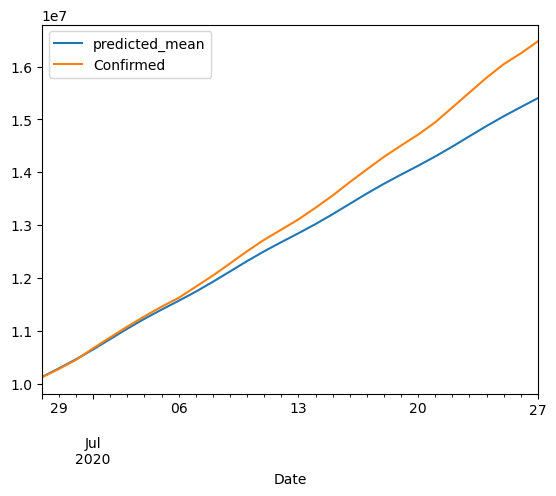

In [45]:
pred.plot(legend=True)
test["Confirmed"].plot(legend=True)

In [46]:
sqrt(mean_squared_error(pred,test["Confirmed"]))

497721.75112151285

In [47]:
start = len(train)
end =   len(data)-1
pred =  model_deaths.predict(start=start,end=end,typ="levels")
print(pred)

2020-06-28    5.033291e+05
2020-06-29    5.073561e+05
2020-06-30    5.123581e+05
2020-07-01    5.181512e+05
2020-07-02    5.241786e+05
                  ...     
2154-05-22    2.479453e+08
2154-05-23    2.479504e+08
2154-05-24    2.479555e+08
2154-05-25    2.479605e+08
2154-05-26    2.479656e+08
Freq: D, Name: predicted_mean, Length: 48910, dtype: float64


<Axes: xlabel='Date'>

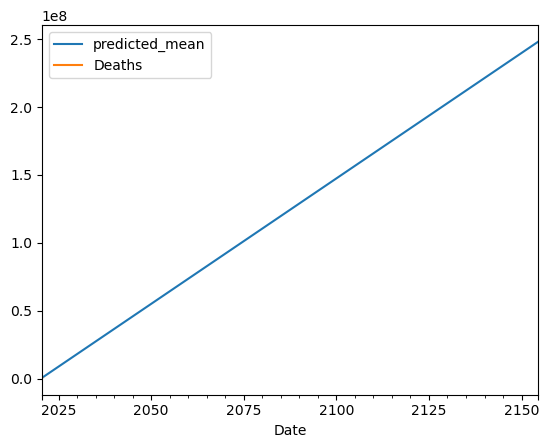

In [56]:
pred.plot(legend=True)
test["Deaths"].plot(legend=True)

In [49]:
scaler = MinMaxScaler()
data['Confirmed'] = scaler.fit_transform(data[['Confirmed']])

In [50]:
def create_dataset(dataset, look_back=1):
     dataX, dataY = [], []
     for i in range(len(dataset) - look_back):
         dataX.append(dataset[i + look_back])
     return np.array(dataX),np.array(dataY)

In [51]:
split_idx = int(len(data)*0.8)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

trainX, trainY = create_dataset(train_data['Confirmed'].values, 30)
testX, testY = create_dataset(test_data['Confirmed'].values,30)

In [52]:
print("shape of train x:",trainX.shape)
print("shape of test x:",testX.shape)

shape of train x: (39224,)
shape of test x: (9784,)


In [67]:

data.size

490680

In [71]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX  = np.reshape(testX,(testX.shape[0], testX.shape[1], 1))


IndexError: tuple index out of range

In [55]:
model = Sequential()
model.add(LSTM(units=150, input_shape=(30, 1)))
model.add(Dense(units=1))
model.compile(loss ='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'testPredict' is not defined

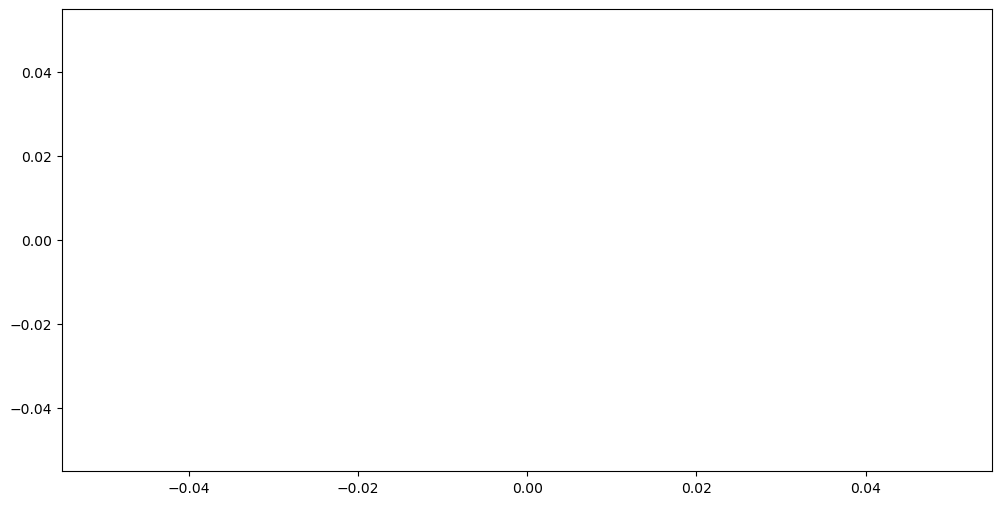

In [73]:
plt.figure(figsize=(12,6))
plt.plot(testY, label='Actual')
plt.plot(testPredict, label ='Predicted')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()